<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this short example, I resort to the CV2 package, which is focused on computer vision to digest an image with text in cursive and extract one specific word, following a model trained with Tensorflow / Keras.

In [1]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from statistics import mean
import tensorflow as tf

The image is read and transformed from color to a two color scale.

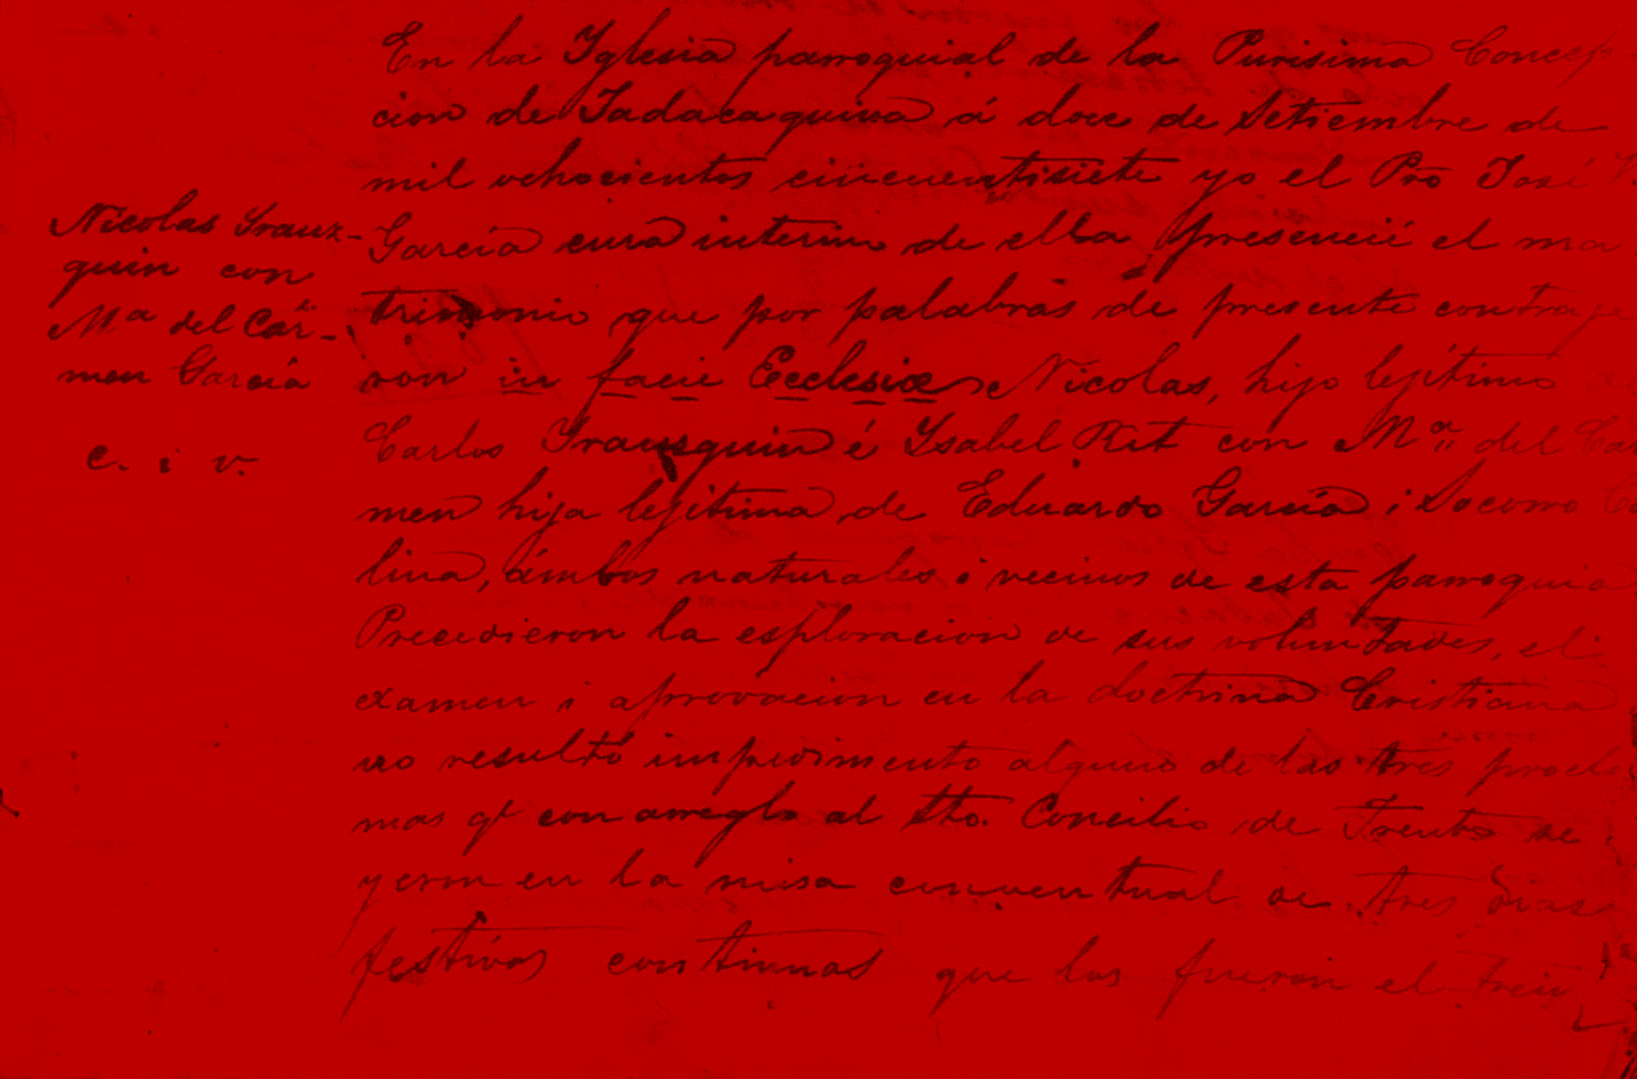

In [2]:
image = cv2.imread('test.jpg')
#convert to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
cv2_imshow(image)

The image is interpreted as a tensor, formed of three points for each pixel. These three points represent the saturation of color.

In [3]:
image

array([[[  0,   0, 183],
        [  0,   0, 192],
        [  0,   0, 194],
        ...,
        [  0,   0, 189],
        [  0,   0, 189],
        [  0,   0, 189]],

       [[  0,   0, 177],
        [  0,   0, 189],
        [  0,   0, 195],
        ...,
        [  0,   0, 189],
        [  0,   0, 189],
        [  0,   0, 189]],

       [[  0,   0, 167],
        [  0,   0, 182],
        [  0,   0, 192],
        ...,
        [  0,   0, 189],
        [  0,   0, 189],
        [  0,   0, 189]],

       ...,

       [[  0,   0, 168],
        [  0,   0, 173],
        [  0,   0, 174],
        ...,
        [  0,   0, 151],
        [  0,   0, 143],
        [  0,   0, 109]],

       [[  0,   0, 161],
        [  0,   0, 168],
        [  0,   0, 171],
        ...,
        [  0,   0, 150],
        [  0,   0, 132],
        [  0,   0, 106]],

       [[  0,   0, 144],
        [  0,   0, 153],
        [  0,   0, 158],
        ...,
        [  0,   0, 156],
        [  0,   0, 128],
        [  0,   0, 103]]

Now, I use the inRange function to set each pixel in a binary classification form, white or black. I have to reverse it later since the standard in machine learning is white-over-black.

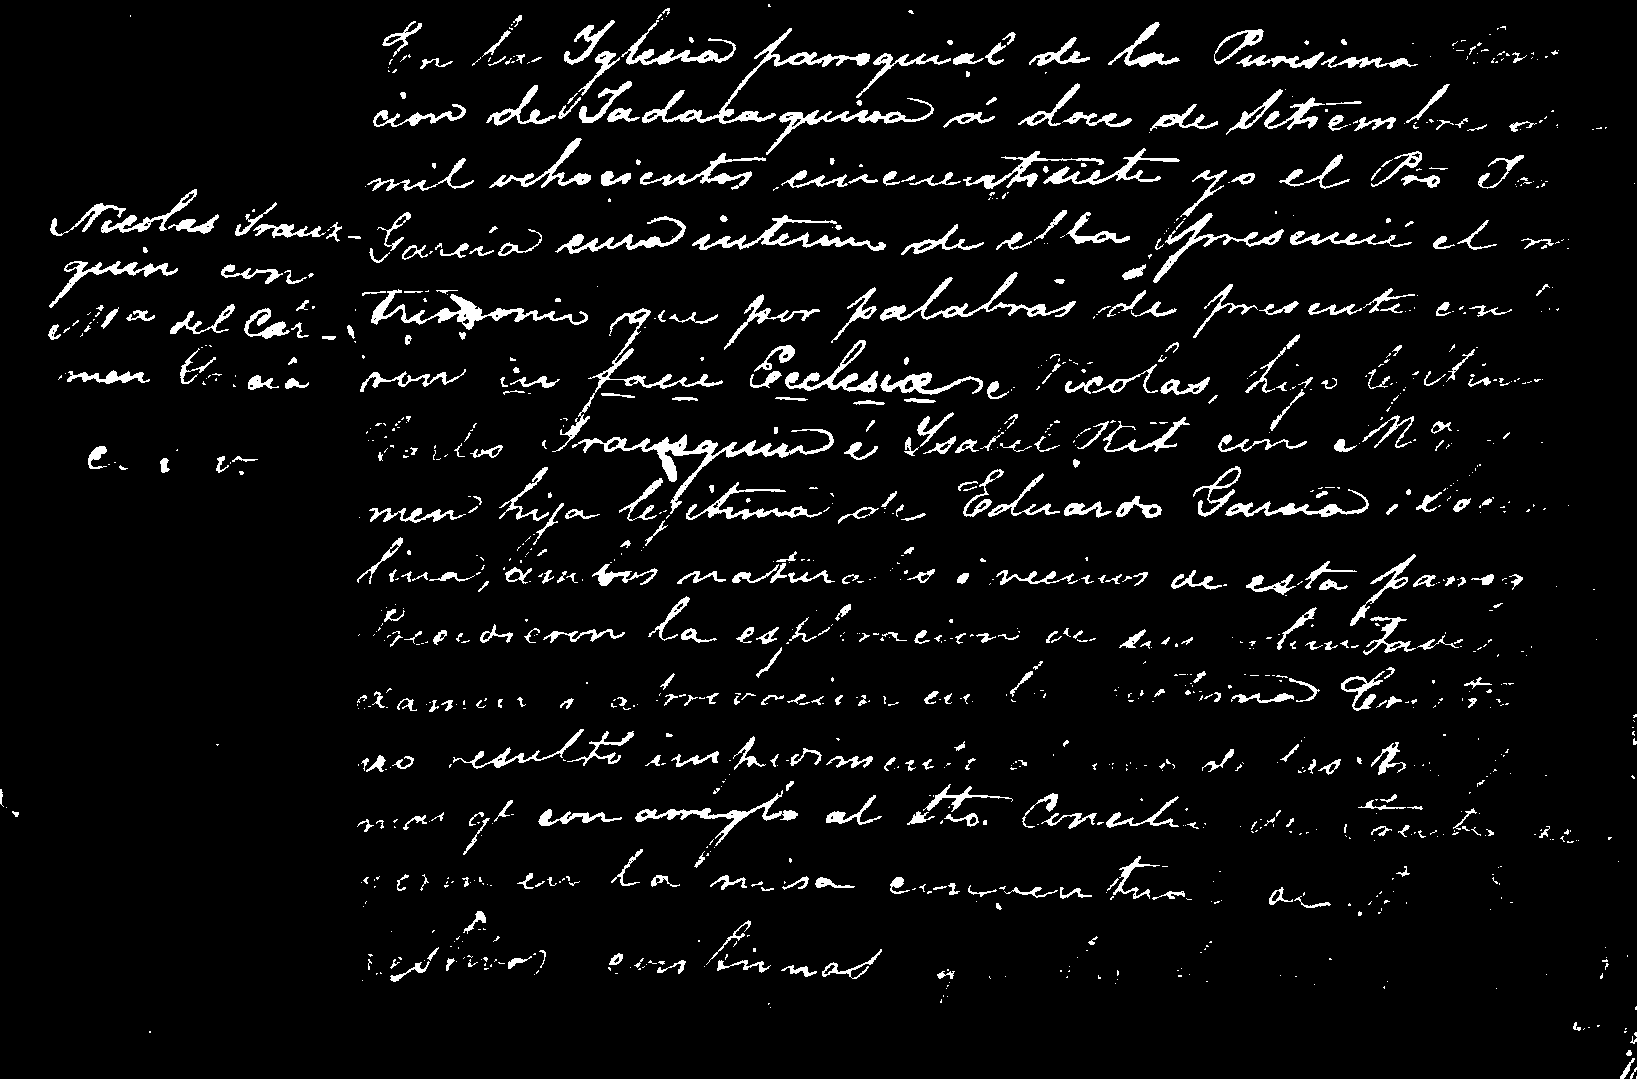

In [4]:
#range limits
#defines ranges to split between black and white
#the higher the value the more sensitive
lower = np.array([0, 0, 120])
upper = np.array([0, 0, 255])
msk = cv2.inRange(image, lower, upper)
#turns black to white and vice versa
msk = cv2.bitwise_not(msk)
cv2_imshow(msk)

The next two functions are erosion and dilation. The first one is done to remove white points that might be noise (imaging sand eroding a rock). The second one is to inflate the white areas to create a fuzzy schema; supposedly, one continuous block has to be one word, or at least close to it.

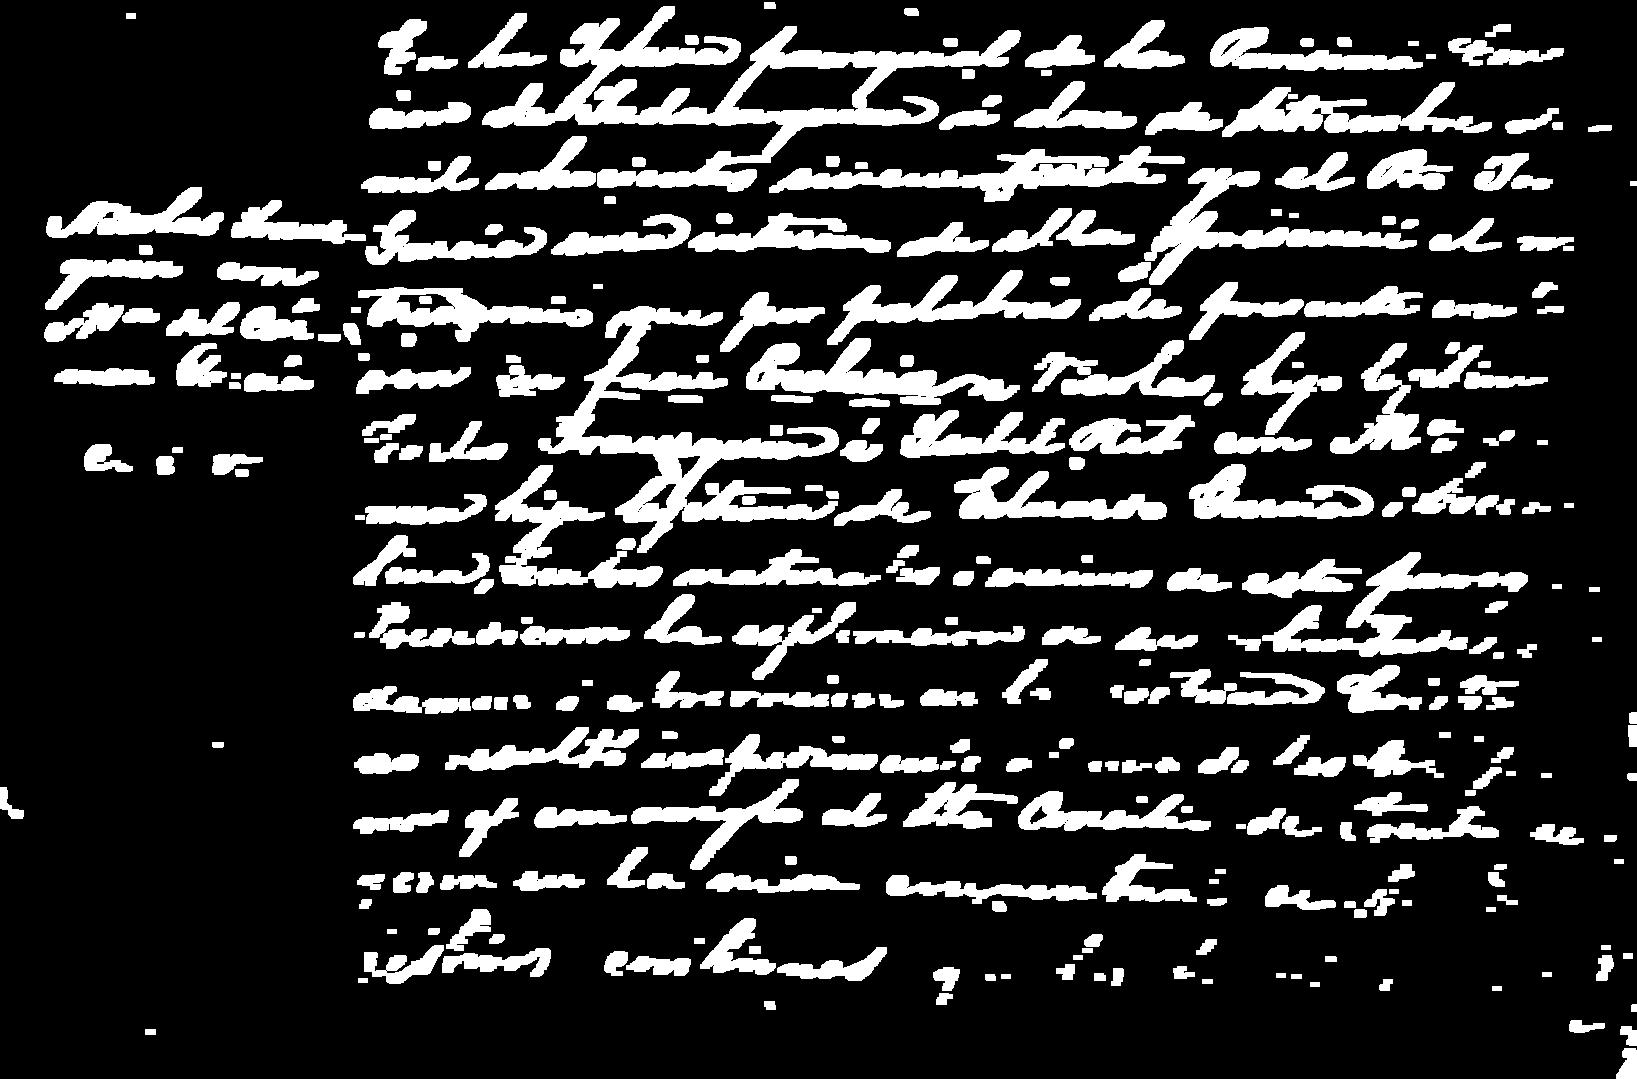

In [5]:
#it is necessary to define a kernel, in this case it is the shape of the figure we want to extract (rectangle, elipse, circle, etc). In this case rectangle
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
#then I erode the whites to remove the noise points, or at least reduce them
rrmsk = cv2.erode(msk,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,5))
rrmsk = cv2.dilate(msk, kernel, iterations=1)
cv2_imshow(rrmsk)

This section is simply an illustration, performed to write the words into the initial image. I also created a word object that stores rectangles of pictures of each word mined this way.

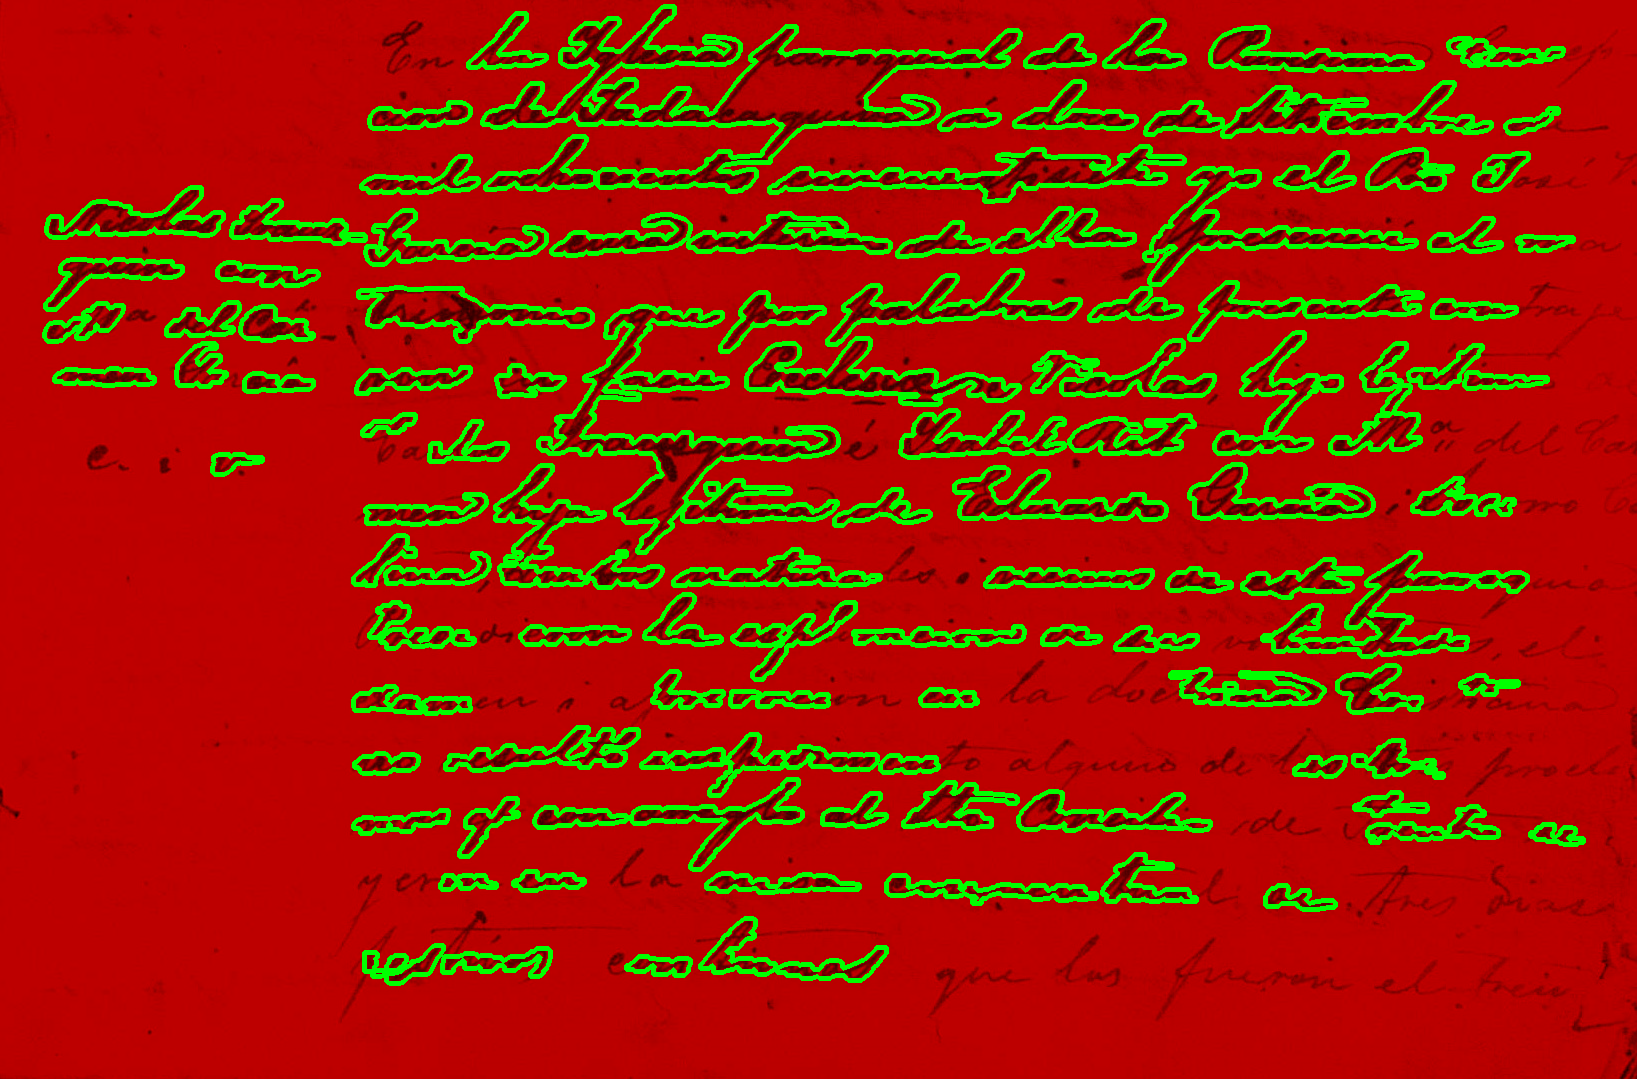

In [6]:
contours, hierarchy = cv2.findContours(rrmsk, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

minw = 50
minh = 10

image = cv2.imread('test.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

cleancontours = []
words = []
for contour in contours:
 x,y,w,h = cv2.boundingRect(contour)
 if ((w>=minw) & (h>=minh)):
  cleancontours.append(contour)
  word = image[y-5:y+h+5,x-5:x+w+5]
  words.append(word)

cleancontours = tuple(cleancontours)

imageC = cv2.imread('test.jpg')
imageC = cv2.cvtColor(imageC, cv2.COLOR_BGR2HSV)
cv2.drawContours(imageC, cleancontours, -1, (0,255,0), 3)
cv2_imshow(imageC)

I take those words and handle them the same way I did in the previous steps.

In [7]:
image = cv2.imread('test.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


lower = np.array([0, 0, 150])
upper = np.array([0, 0, 255])

masks = []
for word in words:
 if len(word) > 0:
  mask = cv2.inRange(word, lower, upper)
  mask = cv2.bitwise_not(mask)
  masks.append(mask)


Here are the positive training samples. I will be looking for the word "Garcia" in the image. I have collected samples of other images for the same word. I cleaned these pictures the same way as described before, then transformed them to the same size (the average of all samples ingested). The third image displayed here is an average of all 16 images.

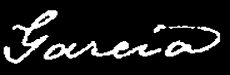

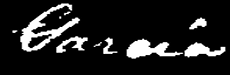

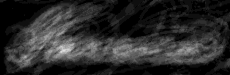

In [8]:
lower = np.array([0, 0, 150])
upper = np.array([0, 0, 255])

samples = ['sample1.jpg','sample2.jpg','sample3.jpg','sample4.jpg','sample5.jpg','sample6.jpg','sample7.jpg','sample8.jpg','sample9.jpg','sample10.jpg','sample11.jpg','sample12.jpg','sample13.jpg','sample14.jpg','sample15.jpg','sample16.jpg']

train = []
hs = []
ws = []
for sample in samples:
 im = cv2.imread(sample)
 im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
 im = cv2.inRange(im, lower, upper)
 im = cv2.bitwise_not(im)
 height, width = im.shape
 hs.append(height)
 ws.append(width)
 train.append(im)

from statistics import mean
hh = int(mean(hs))+1
ww = int(mean(ws))+1


trainr = []
for im in train:
 im = cv2.resize(im, (ww, hh), interpolation = cv2.INTER_CUBIC)
 trainr.append(im)

cv2_imshow(trainr[2])
cv2_imshow(trainr[1])

meanimg = np.mean(trainr, axis=0)
cv2_imshow(meanimg)

I take the average image and transformed into binary values.

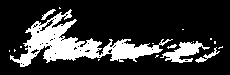

In [9]:
lower = 80
upper = 255
meanimgT = cv2.inRange(meanimg, lower, upper)
cv2_imshow(meanimgT)

In this section, I take the average and extract an euclidean distance from each of the words in the text. Let's see if this simple method gives good results.

In [10]:
minh = min(hs)-20
minw = min(ws)-20
maxh = max(hs)+20
maxw = max(ws)+20

testr = []
for im in masks:
 height, width = im.shape
 if ((height >= minh) & (width >= minw) & (height <= maxh) & (width <= maxw)):
  im = cv2.resize(im, (ww, hh), interpolation = cv2.INTER_CUBIC)
  testr.append(im)

a,b=meanimg.shape
leng = a*b

distc = []
i = 0
for im in testr:
 distance = np.sqrt(np.sum(np.square(meanimg - im)))/leng
 dist = pd.DataFrame({'position':[i], 'distance':[distance]})
 i = i + 1
 distc.append(dist)
distc = pd.concat(distc, axis=0, ignore_index=True)
distc.sort_values('distance')

,position,distance
23,23,0.551916
24,24,0.577495
27,27,0.611962
2,2,0.613168
9,9,0.613646
28,28,0.628906
14,14,0.629045
21,21,0.632686
10,10,0.632938
5,5,0.640665


And.... the closest word is effectively Garcia.

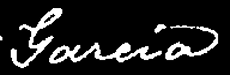

In [26]:
cv2_imshow(testr[23])


In this section, I take seven images of bodies of text, and I process them the same way as with the test image. The idea is to extract a number of dummy pictures of words that I can use as a negative training set.

In [12]:
lower = np.array([0, 0, 120])
upper = np.array([0, 0, 255])

samples2 = ['dummy1.jpg','dummy2.jpg','dummy3.jpg','dummy4.jpg','dummy5.jpg','dummy6.jpg','dummy7.jpg']

minw = 50
minh = 10

train2r = []
for sample in samples2:
 im = cv2.imread(sample)
 im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
 im = cv2.inRange(im, lower, upper)
 im = cv2.bitwise_not(im)
 kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
 im = cv2.erode(im,kernel,iterations = 1)
 kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,5))
 im = cv2.dilate(im, kernel, iterations=1)
 image = cv2.imread(sample)
 image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 for contour in contours:
  x,y,w,h = cv2.boundingRect(contour)
  if ((w>=minw) & (h>=minh)):
   word = image[y-5:y+h+5,x-5:x+w+5]
   if (len(word) > 0):
    try:
     mask = cv2.inRange(word, lower, upper)
     mask = cv2.bitwise_not(mask)
     height, width = mask.shape
     if ((height >= minh) & (width >= minw) & (height <= maxh) & (width <= maxw)):
      mask = cv2.resize(mask, (ww, hh), interpolation = cv2.INTER_CUBIC)
      train2r.append(mask)
    except Exception as error:
     print(error)

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'

OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty()

Length of positive and negative training sets and the test test.

In [13]:
print(len(trainr))
print(len(train2r))
print(len(testr))

16
710
31


This is the core of the neural network model in Keras. In this case, layers are used that support two dimensinal inputs and one dimensial binary output. It required a good number of attempts since the training set is very small and the model jumped fast into an overfitting region. I dealt with that with a low batch size, which allowed "wiggle" in the selection of data for each epoch, and by running it several times on different samples.

In [35]:
from random import sample
train2r_s = sample(train2r,30)

training = trainr + train2r_s
ys = ([1] * len(trainr)) + ([0] * len(train2r_s))
training = np.array(training)
ys = np.array(ys)

#need shape of the input
nn, xx, yy = np.array(training).shape

#initialize
neur = tf.keras.models.Sequential()
#layers
neur.add(tf.keras.layers.Conv2D(5,3, activation='relu', input_shape=(xx,yy,1)))
neur.add(tf.keras.layers.Conv2D(15,3, activation='tanh'))
neur.add(tf.keras.layers.Conv2D(15,3, activation='tanh'))
neur.add(tf.keras.layers.Flatten())
neur.add(tf.keras.layers.Dense(10, activation='tanh'))

#output layer
neur.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#compilation
neur.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#train
neur.fit(np.array(training), np.array(ys), batch_size=15, epochs=3)

Epoch 1/3
4/4 [==============================] - 4s 458ms/step - loss: 0.7326 - accuracy: 0.6522
Epoch 2/3
4/4 [==============================] - 1s 237ms/step - loss: 0.2696 - accuracy: 0.9130
Epoch 3/3
4/4 [==============================] - 1s 238ms/step - loss: 0.2199 - accuracy: 0.9130


To reduce the overfitting, I made a loop to train the model in different random training sets each time. I was able to do this because I had a large sample of negatives. I also needed to account for the high imbalance between positives and negatives.

In [36]:
for i in list(range(0,30)):
 train2r_s = sample(train2r,30)
 training = trainr + train2r_s
 ys = ([1] * len(trainr)) + ([0] * len(train2r_s))
 training = np.array(training)
 ys = np.array(ys)
 print("training part: " + str(i+1))
 neur.fit(np.array(training), np.array(ys), batch_size=30, epochs=3)

training part: 1
Epoch 1/3
2/2 [==============================] - 1s 390ms/step - loss: 0.3024 - accuracy: 0.8478
Epoch 2/3
2/2 [==============================] - 1s 330ms/step - loss: 0.2731 - accuracy: 0.8478
Epoch 3/3
2/2 [==============================] - 1s 363ms/step - loss: 0.2664 - accuracy: 0.8478
training part: 2
Epoch 1/3
2/2 [==============================] - 1s 346ms/step - loss: 0.2283 - accuracy: 0.9130
Epoch 2/3
2/2 [==============================] - 2s 688ms/step - loss: 0.2348 - accuracy: 0.8913
Epoch 3/3
2/2 [==============================] - 2s 491ms/step - loss: 0.2289 - accuracy: 0.8913
training part: 3
Epoch 1/3
2/2 [==============================] - 1s 369ms/step - loss: 0.2403 - accuracy: 0.9130
Epoch 2/3
2/2 [==============================] - 1s 335ms/step - loss: 0.2366 - accuracy: 0.8913
Epoch 3/3
2/2 [==============================] - 1s 341ms/step - loss: 0.2148 - accuracy: 0.9130
training part: 4
Epoch 1/3
2/2 [==============================] - 1s 351ms/s

Run on thest, unseen data.

In [37]:
test_out = neur.predict(np.array(testr))
pd.DataFrame(test_out).sort_values(0, ascending=False)

1/1 [==============================] - 1s 637ms/step


,0
23,0.899719
14,0.756980
21,0.752947
24,0.750876
7,0.684984
2,0.684587
28,0.520462
11,0.432943
12,0.355382
9,0.354066


Extract the top testing image (value closest to 1), which is effectively the word Garcia.

[0.89971906]


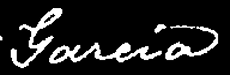

In [40]:
check = 23
print(test_out[check])
cv2_imshow(testr[check])